**Fetching all USA airports information

In [309]:
import requests
import re
from bs4 import BeautifulSoup
import pandas as pd
import time
import sys
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import json
import numpy as np

from typing import Dict, List
from tqdm import tqdm_notebook
from fake_useragent import UserAgent

In [2]:
url_main = "https://www.flightconnections.com/"
url_codes = "airport-codes"

In [3]:
def get_soup(url):
    res = requests.get(url, headers={'User-Agent': UserAgent().chrome})
    html = res.content
    soup = BeautifulSoup(html, 'lxml')
    return soup

In [4]:
soup = get_soup(url_main + url_codes)

In [5]:
airport_list = soup.findAll("ul", attrs={"class":"airport-list"})
airport_list = [airport_group.findAll("li") for airport_group in airport_list]
airport_list = sum(airport_list, [])

In [6]:
def get_airport_info(airport)->Dict[str,str]:
    link = airport.find("a").get("href")
    link = link.replace("-to-", "-from-")
    code = airport.find("span", attrs={"class":"airport-code"}).text
    name = airport.find("span", attrs={"class":"airport-name"}).text
    city_country = airport.find("span", attrs={"class":"airport-city-country"}).text
    cc = city_country.split(", ")
    city = cc[0]
    country = cc[1]
    return {"link":link, "code":code, "name":name, "city":city, "country":country}

In [7]:
airport_info = []

for airport in tqdm_notebook(airport_list):
    airport = get_airport_info(airport)
    if airport["country"] == "United States":
        airport_info.append(airport)

<ipython-input-7-c2e010333845>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for airport in tqdm_notebook(airport_list):


In [8]:
result = pd.DataFrame(airport_info)
result.to_csv("../data/airport_info.csv")

In [9]:
airport_info = pd.read_csv("../data/airport_info.csv", index_col=0)
airport_info.head()

,link,code,name,city,country
0,/flights-from-allentown-abe,ABE,Lehigh Valley International Airpo,Allentown,United States
1,/flights-from-abilene-abi,ABI,Abilene Regional Airport,Abilene,United States
2,/flights-from-ambler-abl,ABL,Ambler Airport (FAA: AFM),Ambler,United States
3,/flights-from-albuquerque-abq,ABQ,Albuquerque International Sunport,Albuquerque,United States
4,/flights-from-aberdeen-abr,ABR,Aberdeen Regional Airport,Aberdeen,United States


## Visiting every airport link in USA and finding connections in USA

In [10]:
def get_airport_info(destination, source_airport)->Dict[str,str]:
    name = destination.find("div", attrs={"class":"popular-destination-airport-name"}).text
    destination_code = re.findall("\((.*?)\)", name)[0]
    country = destination.find("img").get("title")
    
    destination_flights_per_month = destination.find("span", attrs={'class':"float-right"}).text.strip()
    destination_flights_per_month = re.findall('\d+', destination_flights_per_month)[0]
    if destination_flights_per_month.isdigit():
        destination_flights_per_month = int(destination_flights_per_month)
    
    return {"source_code":source_airport, "destination_code": destination_code, "flights_per_month": destination_flights_per_month, "country":country}

In [11]:
def get_destinations_info(url_airport, source_airport)->List[Dict]:
#     print(url_main)
#     print(url_airport)
    flights_info = get_soup(url_main + url_airport)
    
    popular_destinations = flights_info.findAll("a", attrs={"class":"popular-destination btn"})
    popular_destinations_hidden = soup.findAll("a", attrs={"class":"popular-destination btn hide"})
    popular_destinations = popular_destinations_hidden + popular_destinations
#     print(popular_destinations)
    
    destinations_info = []

    for destination in tqdm_notebook(popular_destinations):
        destination = get_airport_info(destination, source_airport)
        if destination["country"] == "United States":
            destinations_info.append(destination)
    return destinations_info

In [ ]:
full_destination_routes = []

exceptions = []

for row in tqdm_notebook(airport_info.itertuples(), total=airport_info.shape[0]):
    url_airport = row.link
#     print(url_airport)
    source_airport = row.code
#     print(source_airport)
    try:
        destinations = get_destinations_info(url_airport, source_airport)
        full_destination_routes.extend(destinations)
    except Exception as e:
        if e == KeyboardInterrupt:
            break            
        else:
            print(e, url_airport, source_code)
        exceptions.append([e, url_airport, source_code])
    time.sleep(0.5)

In [107]:
full_destination_routes = pd.DataFrame(full_destination_routes)
full_destination_routes.to_csv("../data/routes.csv")

In [108]:
full_destination_routes.shape

(3748, 4)

In [109]:
full_destination_routes

,source_code,destination_code,flights_per_month,country
0,ABE,DTW,88,United States
1,ABE,CLT,79,United States
2,ABE,ORD,56,United States
3,ABE,ATL,42,United States
4,ABE,SFB,31,United States
...,...,...,...,...
3743,YAK,JNU,30,United States
3744,YAK,CDV,30,United States
3745,YKM,SEA,62,United States
3746,YUM,PHX,98,United States


## Fetching Airport Data Dump from https://openflights.org/data.html

In [249]:
airport_col = ['ID', 'Name', 'City', 'Country','IATA', 'ICAO', 'Lat', 'Long', 'Alt', 
               'Timezone', 'DST', 'Tz database time zone', 'type', 'source']
airport_data = pd.read_csv("https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat",
                        names = airport_col, index_col = 0)
airport_data = airport_data.drop(['ICAO','source', 'type','Tz database time zone','DST','Timezone','Alt'], axis=1)
airport_data.to_csv("../data/airport_data_openflights.csv")


In [255]:
#Pre-processing the airport data to filter for United States only and removing unecessary columns.

filePath = "../data/airport_data_openflights.csv"
with open(filePath)	as csvfile:
    reader = csv.DictReader(csvfile)

    filePath = "../data/temp.csv"
    with open(filePath,'w',newline='') as csvfile:
#         fieldnames = ['ID','Name','City','Country','IATA','ICAO','Lat','Long','Alt','Timezone','DST','Tz database time zone','type','source']
        fieldsnames = ['ID','Name','City','Country','IATA','Lat','Long']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

        for row in reader:
            if row['Country'] == "United States":
                writer.writerow(row)

# header_list = ['ID','Name','City','Country','IATA','Lat','Long']
# airport_data = pd.read_csv("../data/temp.csv", names=header_list)
airport_data = pd.read_csv("../data/temp.csv")
airport_data = airport_df[~airport_df.IATA.isin([r"\N"])]
airport_data.to_csv('../data/airport_data_openflights_cleaned.csv', index=False)

In [256]:
airport_data.head()

,ID,Name,City,Country,IATA,Lat,Long
0,3411,Barter Island LRRS Airport,Barter Island,United States,BTI,70.134003,-143.582001
2,3413,Cape Lisburne LRRS Airport,Cape Lisburne,United States,LUR,68.875099,-166.110001
3,3414,Point Lay LRRS Airport,Point Lay,United States,PIZ,69.732903,-163.005005
4,3415,Hilo International Airport,Hilo,United States,ITO,19.721399,-155.048004
5,3416,Orlando Executive Airport,Orlando,United States,ORL,28.545500,-81.332901


## Fetching Airport Connections Data Dump From https://openflights.org/data.html

In [271]:
connections_cols = ['Airline', 'Airline ID', 'Source Airport', 'Source Airport ID',
              'Dest Airport', 'Dest Airport ID', 'Codeshare', 'Stops', 'equipment']
connections_world = pd.read_csv("https://raw.githubusercontent.com/jpatokal/openflights/master/data/routes.dat",
                        names = connections_cols)
connections_world.to_csv("../data/connections_world.csv")

In [272]:
connections_world.shape

(67663, 9)

## Plotting Python Scatter Plot of US Airports across latitude vs longitude

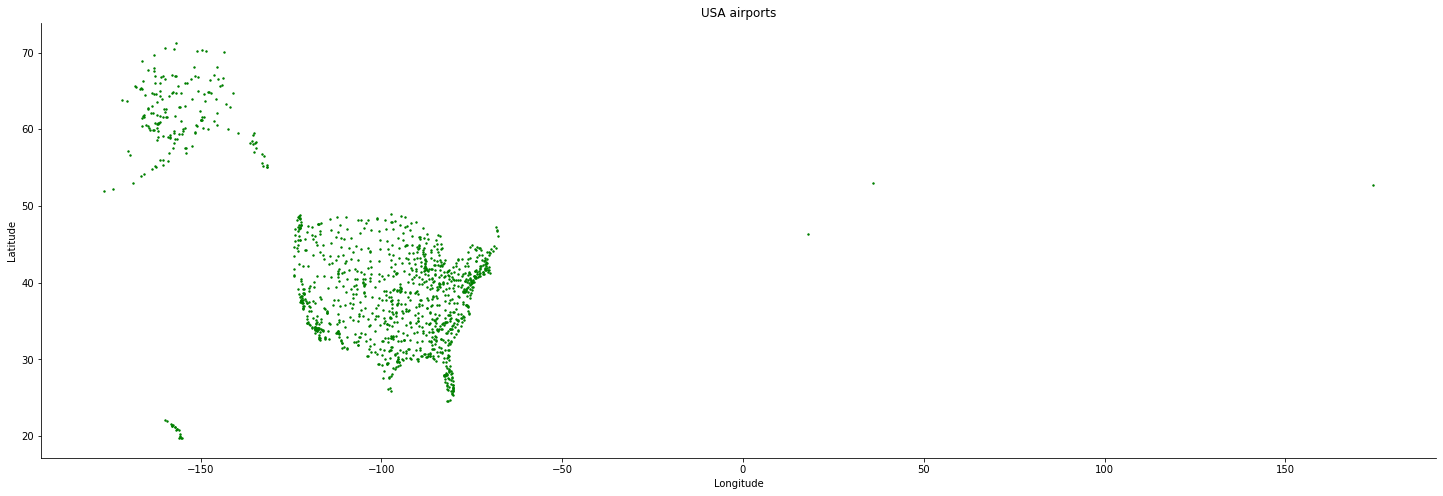

In [273]:
# full_destination_routes -> From routes.csv
# connections_world -> connections_world.csv
# airport_data -> airport_data_openflights_cleaned.csv

plt.figure(figsize=(25, 8))
plt.title("USA airports")
plt.scatter(airport_data.Long, airport_data.Lat, s=2, c='green')
plt.ylabel("Latitude")
plt.xlabel("Longitude")
sns.despine()
plt.show()

## Left join US airports destination routes with all connections in world data

In [274]:
connections = pd.merge(
    full_destination_routes,
    connections_world,
    how='left', 
    left_on=['source_code', 'destination_code'], 
    right_on=['Source Airport', 'Dest Airport']
)

connections.drop(
    ['source_code', 'destination_code', 'Codeshare', 'Stops', 'equipment'],
    axis=1, inplace=True
)

connections.columns = connections.columns.str.lower().str.split().str.join("_")
connections.head()

,flights_per_month,country,airline,airline_id,source_airport,source_airport_id,dest_airport,dest_airport_id
0,88,United States,DL,2009,ABE,4355,DTW,3645
1,79,United States,AA,24,ABE,4355,CLT,3876
2,79,United States,US,5265,ABE,4355,CLT,3876
3,56,United States,UA,5209,ABE,4355,ORD,3830
4,42,United States,AF,137,ABE,4355,ATL,3682


In [275]:
# Checking if any valuable data is missing
connections.isnull().sum()/connections.shape[0]

flights_per_month    0.000000
country              0.000000
airline              0.152399
airline_id           0.152399
source_airport       0.152399
source_airport_id    0.152399
dest_airport         0.152399
dest_airport_id      0.152399
dtype: float64

## Adding US Airports Longitude and Latitude data to connections table above

In [276]:
connections = pd.merge(
    connections, airport_data[['IATA', 'Lat', 'Long']], left_on='source_airport', right_on='IATA')

connections = pd.merge(
    connections, airport_data[['IATA', 'Lat', 'Long']], left_on='dest_airport', right_on='IATA')

connections.drop(['IATA_x', 'IATA_y'], axis=1, inplace=True)
connections.rename(columns={
    'Lat_x':'latitude_source', 
    'Long_x':'longitude_source',
    'Lat_y':'latitude_dest',
    'Long_y':'longitude_dest'
}, inplace=True)
connections.head()
connections.to_csv("../data/temp_connections.csv")

## Adding top 200 fetched US cities population to airport_data

In [190]:
# Run US_Cities_Population.ipynb first to get the us_top_200_city_population.csv file generated

population_city = pd.read_csv("../data/us_top_200_city_population.csv", index_col=0)
print(population_city.shape)
population_city.head()

(200, 8)


,Rank,Name,State,2020 Pop,2010 Census,Change,Density (km²),Area (km²)
0,1,New York City,New York,8323340,8190360,1.62%,10699,778
1,2,Los Angeles,California,4015940,3795370,5.81%,3306,1215
2,3,Chicago,Illinois,2694240,2697530,-0.12%,4575,589
3,4,Houston,Texas,2340890,2098450,11.55%,1412,1658
4,5,Phoenix,Arizona,1703080,1449300,17.51%,1270,1341


## Fetching Population Data from a more bigger dataset from opendatasoft.com

In [233]:
resp = requests.get('https://public.opendatasoft.com/api/records/1.0/search/?dataset=geonames-all-cities-with-a-population-1000&q=&rows=10000&sort=population&facet=timezone&facet=country&refine.country=United+States')
outDict = json.loads(resp.text)

cityPop = []

for record in outDict["records"]:
    name = record["fields"]["name"]
    population = record["fields"]["population"]
    cityPop.append({"name":name, "population":population})

cityPop = pd.DataFrame(cityPop)
cityPop.to_csv("../data/us_all_cities_population.csv")

In [234]:
cityPop.head()

,name,population
0,New York City,8175133
1,Los Angeles,3971883
2,Chicago,2720546
3,Brooklyn,2300664
4,Houston,2296224


In [263]:
airport_data = pd.read_csv("../data/airport_data_openflights_cleaned.csv")
airport_data.head()

,ID,Name,City,Country,IATA,Lat,Long
0,3411,Barter Island LRRS Airport,Barter Island,United States,BTI,70.134003,-143.582001
1,3413,Cape Lisburne LRRS Airport,Cape Lisburne,United States,LUR,68.875099,-166.110001
2,3414,Point Lay LRRS Airport,Point Lay,United States,PIZ,69.732903,-163.005005
3,3415,Hilo International Airport,Hilo,United States,ITO,19.721399,-155.048004
4,3416,Orlando Executive Airport,Orlando,United States,ORL,28.545500,-81.332901


In [264]:
airport_merged_data = pd.merge(
    airport_data, 
    cityPop.rename(
        columns={"name":"City"}
    ).drop_duplicates(subset=['City']), 
    how='left',
    on='City'
)
airport_merged_data.to_csv("../data/us_airport_population_merged.csv")
airport_merged_data.head()

,ID,Name,City,Country,IATA,Lat,Long,population
0,3411,Barter Island LRRS Airport,Barter Island,United States,BTI,70.134003,-143.582001,NaN
1,3413,Cape Lisburne LRRS Airport,Cape Lisburne,United States,LUR,68.875099,-166.110001,NaN
2,3414,Point Lay LRRS Airport,Point Lay,United States,PIZ,69.732903,-163.005005,NaN
3,3415,Hilo International Airport,Hilo,United States,ITO,19.721399,-155.048004,43263.0
4,3416,Orlando Executive Airport,Orlando,United States,ORL,28.545500,-81.332901,270934.0


In [277]:
airport_merged_data.isnull().sum()/airport_merged_data.shape[0]*100

ID             0.000000
Name           0.000000
City           0.000000
Country        0.000000
IATA           0.000000
Lat            0.000000
Long           0.000000
population    25.259792
dtype: float64

### For 25% cities population is missing, so Hypothesis - the number of flights from the city is proportional to the city population

In [282]:
flights_number = connections.groupby(
    ['source_airport'], as_index=False
)[['flights_per_month']].sum()
flights_number.head()

,source_airport,flights_per_month
0,ABE,485
1,ABI,266
2,ABL,100
3,ABQ,2329
4,ABR,62


In [283]:
# adding source airport number of flights to the airport dataframe
airport_merged_data_with_flightsCount = pd.merge(
    airport_merged_data, flights_number, 
    how='left', 
    left_on='IATA', 
    right_on='source_airport'
)
airport_merged_data_with_flightsCount.head()

,ID,Name,City,Country,IATA,Lat,Long,population,source_airport,flights_per_month
0,3411,Barter Island LRRS Airport,Barter Island,United States,BTI,70.134003,-143.582001,NaN,BTI,27.0
1,3413,Cape Lisburne LRRS Airport,Cape Lisburne,United States,LUR,68.875099,-166.110001,NaN,LUR,4.0
2,3414,Point Lay LRRS Airport,Point Lay,United States,PIZ,69.732903,-163.005005,NaN,PIZ,27.0
3,3415,Hilo International Airport,Hilo,United States,ITO,19.721399,-155.048004,43263.0,ITO,634.0
4,3416,Orlando Executive Airport,Orlando,United States,ORL,28.545500,-81.332901,270934.0,NaN,NaN


In [313]:
airport_data = airport_merged_data_with_flightsCount[~airport_merged_data_with_flightsCount.source_airport.isnull()]
airport_data = airport_data[~airport_data.flights_per_month.isnull()]
airport_data.head()

,ID,Name,City,Country,IATA,Lat,Long,population,source_airport,flights_per_month
0,3411,Barter Island LRRS Airport,Barter Island,United States,BTI,70.134003,-143.582001,NaN,BTI,27.0
1,3413,Cape Lisburne LRRS Airport,Cape Lisburne,United States,LUR,68.875099,-166.110001,NaN,LUR,4.0
2,3414,Point Lay LRRS Airport,Point Lay,United States,PIZ,69.732903,-163.005005,NaN,PIZ,27.0
3,3415,Hilo International Airport,Hilo,United States,ITO,19.721399,-155.048004,43263.0,ITO,634.0
5,3417,Bettles Airport,Bettles,United States,BTT,66.913902,-151.529007,NaN,BTT,31.0


In [314]:
airport_data.isnull().sum()/airport_data.shape[0]*100

ID                    0.000000
Name                  0.000000
City                  0.000000
Country               0.000000
IATA                  0.000000
Lat                   0.000000
Long                  0.000000
population           27.548807
source_airport        0.000000
flights_per_month     0.000000
dtype: float64

### Find USA Population from https://worldpopulationreview.com/countries/united-states-population

In [315]:
population_link = "https://worldpopulationreview.com/countries/united-states-population"
soup = get_soup(population_link)

In [316]:
usa_population = soup.find("span", attrs={"style":"font-size: 36px;"}).text
usa_population = int(usa_population.replace(',',''))
usa_population

331848096

In [317]:
# average population per flight
flights_coefs = airport_data[
    ~airport_data.population.isnull()
].groupby("Country")[['flights_per_month']].sum()
flights_coefs['total_population'] = usa_population
flights_coefs['coef'] = usa_population/flights_coefs['flights_per_month']

In [318]:
flights_coefs

,flights_per_month,total_population,coef
Country,,,
United States,740535.0,331848096,448.119395


### Using this coefficient to fill the missing population data

In [319]:
airport_data['flights_coefficient'] = airport_data.Country.map(flights_coefs.coef)
airport_data['flights_coefficient'].fillna(airport_data['flights_coefficient'].median(), inplace=True)

In [320]:
city_estimates = np.ceil(airport_data.flights_coefficient[airport_data.population.isnull()] *\
                 airport_data.flights_per_month[airport_data.population.isnull()])

airport_data.population[airport_data.population.isnull()] = city_estimates

<ipython-input-320-e5d88e543a9d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  airport_data.population[airport_data.population.isnull()] = city_estimates


In [321]:
airport_data.isnull().sum()/airport_data.shape[0]*100

ID                     0.0
Name                   0.0
City                   0.0
Country                0.0
IATA                   0.0
Lat                    0.0
Long                   0.0
population             0.0
source_airport         0.0
flights_per_month      0.0
flights_coefficient    0.0
dtype: float64

### Cleaning connections data

In [322]:
connections = connections[connections.source_airport.isin(airport_data.IATA)]
connections = connections[connections.dest_airport.isin(airport_data.IATA)]

### Get daily flights estimates

In [323]:
connections.flights_per_month = connections.flights_per_month/30

In [324]:
airport_data.to_csv("../data/airport_data_preprocessed.csv")
connections.to_csv("../data/connections_preprocessed.csv")